<a href="https://colab.research.google.com/github/cinumell/stock_price_prediction_Deep_Learning/blob/main/Companies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction 



1.   Amazon - AMZN
2.   Apple - AAPL
3.   Microsoft - MSFT
4. Google - GOOGL
5. Tesla - TSLA
6. Oracle - ORCL


We are downloading datasets from https://www.tiingo.com/. We will evaluate datasets from various firms. We used Google and Microsoft databases for our baseline calculations.

With a ratio of 80:20, we want to divide the Tiingo dataset into training and validation datasets. The exact training data and validation (test) data values may be different depending on the company symbol. To train the three different models, we will need the dataset's opening price, closing price,high price,and low price labels (prediction labels/classes). 

As the training dataset, we will first extract 80% of the opening price, closing price,high price, and low price labels from the Tiingo dataset. The remaining 20% of the opening price,closing price,high price,candclow price labels from the primary dataset will be extracted as the validation (test) dataset.

In [ ]:
# Dataset download
import pandas_datareader as pr
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Converting data to timeseries input

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



def run_on_lstm_company_stock_price(company_tingo, company_name):
    step = 70 # time step
    company = company_tingo
    price_type = 'close'
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(14,8))

    data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")
    data.to_csv(company+'.csv')

    data = pd.read_csv(company+'.csv')



    #Baseline calculation

    Base_errors = []

    for types in ['open','close','high','low']:
        Price = data[types]
        Means = list()

        for i in range(len(Price) - step):
            Means.append(sum(Price[i:i+step])/step)  

        Error = math.sqrt(mean_squared_error(Price[step:],Means))
        Base_errors.append(Error)   
        print("Base case error for",types,"=",Error)    
    #plt.plot(Price)
    
    Price = data[price_type]

    # MinMax Scalimg
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

    mms = MinMaxScaler(feature_range=(0,1))
    Price = mms.fit_transform(np.array(Price).reshape(-1,1))

    # Dataset split into train and test sets

    train_size = int(len(Price)*0.80)
    test_size = len(Price)-train_size
    train_data,test_data = Price[0:train_size,:],Price[train_size:len(Price),:1]
    
    time_step = step
    trainX, trainY = create_dataset(train_data, time_step)
    testX, testY = create_dataset(test_data, time_step)

    print(trainX.shape), print(trainY.shape)
    print(testX.shape), print(testY.shape)

    trainX = trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
    testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

    # Stacked LSTM model

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dense

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (step, 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

    # Prediction and error calculation

    train_predict = model.predict(trainX)
    test_predict = model.predict(testX)

    print(test_predict.shape)
    testY = testY.reshape(test_size-step-1,1)
    trainY = trainY.reshape(train_size-step-1,1)

    testY = mms.inverse_transform(testY)
    trainY = mms.inverse_transform(trainY)

    print(testY[0])
    print(trainY[0])

    train_predict = mms.inverse_transform(train_predict)
    test_predict = mms.inverse_transform(test_predict)

    print(train_predict[0])
    print(test_predict[0])

    print("Train data error =",math.sqrt(mean_squared_error(trainY,train_predict)))
    print("Test data error =",math.sqrt(mean_squared_error(testY,test_predict)))

    plt.style.use("seaborn-darkgrid")
    fig,ax = plt.subplots(figsize=(14,8))
    #Customize
    ax.set(title=f'{company_name.capitalize()}', 
       xlabel='Time Step (k)',
       ylabel='Price ($)')
    ax.plot(test_predict,label = "predicted")
    ax.plot(testY,label = "actual")
    ax.legend()
    return

## Performance evaluation for 6 companies

We used our companies dataset on LTSM model and checked for the mean squared error of each company for LTSM model. 
The six companies that we ran the model for are Amazon, Apple, Microsoft, Google, Tesla, Oracle. 

The actual and predicted accuracy for all these companies is comparable and the model works with good accuracy.

/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_46910/2079590052.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


Base case error for open = 418.8011369194473
Base case error for close = 417.60953448592136
Base case error for high = 423.8886851069401
Base case error for low = 411.6447011904017
(934, 70)
(934,)
(181, 70)
(181,)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_35 (LSTM)              (None, 64)                49408     
                                                                 
 dense_34 (Dense)            (None, 25)                1625      
                                                                 
 dense_35 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
______________________________

2022-11-29 02:04:13.209805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:04:13.349474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:04:13.558696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:04:13.864350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:04:14.179710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0719

2022-11-29 02:04:16.223003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:04:16.269550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:04:16.396591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 5s 167ms/step - loss: 0.0719 - val_loss: 0.0219
Epoch 2/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0055 - val_loss: 0.0199
Epoch 3/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0031 - val_loss: 0.0183
Epoch 4/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0015 - val_loss: 0.0151
Epoch 5/100
15/15 [==============================] - 1s 45ms/step - loss: 8.8446e-04 - val_loss: 0.0123
Epoch 6/100
15/15 [==============================] - 1s 44ms/step - loss: 6.8324e-04 - val_loss: 0.0115
Epoch 7/100
15/15 [==============================] - 1s 45ms/step - loss: 6.7391e-04 - val_loss: 0.0110
Epoch 8/100
15/15 [==============================] - 1s 45ms/step - loss: 6.6073e-04 - val_loss: 0.0114
Epoch 9/100
15/15 [==============================] - 1s 47ms/step - loss: 6.8027e-04 - val_loss: 0.0114
Epoch 10/100
15/15 [==============================] - 1s 42ms/step - loss: 6.5980e-04 - val

2022-11-29 02:05:20.442980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:05:20.486694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:05:20.607170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 49ms/step
(181, 1)
[2936.35]
[1591.]
[1566.5022]
[2831.5312]
Train data error = 68.80334725026569
Test data error = 286.5820409524333


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_46910/2079590052.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


Base case error for open = 48.71431074804874
Base case error for close = 48.88487291431131
Base case error for high = 49.14165770734546
Base case error for low = 48.32583093752489
(934, 70)
(934,)
(181, 70)
(181,)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_37 (LSTM)              (None, 64)                49408     
                                                                 
 dense_36 (Dense)            (None, 25)                1625      
                                                                 
 dense_37 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_______________________________

2022-11-29 02:05:24.266686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:05:24.394360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:05:24.525049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:05:24.738274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:05:25.007817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0224

2022-11-29 02:05:26.905080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:05:26.951740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:05:27.094883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 159ms/step - loss: 0.0224 - val_loss: 7.3708e-04
Epoch 2/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0056 - val_loss: 5.2595e-04
Epoch 3/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0045 - val_loss: 2.6293e-04
Epoch 4/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0040 - val_loss: 3.6563e-04
Epoch 5/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0037 - val_loss: 8.0820e-04
Epoch 6/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0039 - val_loss: 2.3127e-04
Epoch 7/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0034 - val_loss: 2.5431e-04
Epoch 8/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0032 - val_loss: 6.3565e-04
Epoch 9/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0031 - val_loss: 6.3244e-04
Epoch 10/100
15/15 [==============================] - 1s 43ms/step - loss: 

2022-11-29 02:06:31.182433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:06:31.228886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:06:31.351577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 55ms/step
(181, 1)
[158.52]
[178.44]
[178.1395]
[159.75656]
Train data error = 13.029803646533152
Test data error = 4.2186251514685775


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_46910/2079590052.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


Base case error for open = 15.00300880908542
Base case error for close = 15.012720979741655
Base case error for high = 14.770710803584128
Base case error for low = 15.072478392433267
(934, 70)
(934,)
(181, 70)
(181,)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_39 (LSTM)              (None, 64)                49408     
                                                                 
 dense_38 (Dense)            (None, 25)                1625      
                                                                 
 dense_39 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
____________________________

2022-11-29 02:06:34.768265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:06:34.892740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:06:35.023131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:06:35.240331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:06:35.503285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0305

2022-11-29 02:06:37.450420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:06:37.501869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:06:37.624902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 154ms/step - loss: 0.0305 - val_loss: 0.0052
Epoch 2/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 4/100
15/15 [==============================] - 1s 43ms/step - loss: 6.6362e-04 - val_loss: 0.0018
Epoch 5/100
15/15 [==============================] - 1s 45ms/step - loss: 5.3698e-04 - val_loss: 0.0019
Epoch 6/100
15/15 [==============================] - 1s 44ms/step - loss: 5.0544e-04 - val_loss: 0.0018
Epoch 7/100
15/15 [==============================] - 1s 44ms/step - loss: 4.7915e-04 - val_loss: 0.0023
Epoch 8/100
15/15 [==============================] - 1s 46ms/step - loss: 4.6275e-04 - val_loss: 0.0022
Epoch 9/100
15/15 [==============================] - 1s 42ms/step - loss: 4.5657e-04 - val_loss: 0.0021
Epoch 10/100
15/15 [==============================] - 1s 46ms/step - loss: 4.5315e-04 -

2022-11-29 02:07:41.602762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:07:41.652004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:07:41.775291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 52ms/step
(181, 1)
[285.59]
[93.85]
[95.95911]
[284.5366]
Train data error = 3.5169182552431737
Test data error = 7.344069228415182


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_46910/2079590052.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


Base case error for open = 335.2760757785852
Base case error for close = 335.51427293620236
Base case error for high = 339.3391364123283
Base case error for low = 331.44881528923725
(934, 70)
(934,)
(181, 70)
(181,)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_41 (LSTM)              (None, 64)                49408     
                                                                 
 dense_40 (Dense)            (None, 25)                1625      
                                                                 
 dense_41 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_____________________________

2022-11-29 02:07:45.209353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:07:45.352106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:07:45.487896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:07:45.678041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:07:45.889847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0486

2022-11-29 02:07:47.864893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:07:47.911942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:07:48.029492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 161ms/step - loss: 0.0486 - val_loss: 0.0262
Epoch 2/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0047 - val_loss: 0.0213
Epoch 3/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0023 - val_loss: 0.0174
Epoch 4/100
15/15 [==============================] - 1s 42ms/step - loss: 6.9376e-04 - val_loss: 0.0166
Epoch 5/100
15/15 [==============================] - 1s 44ms/step - loss: 3.5749e-04 - val_loss: 0.0168
Epoch 6/100
15/15 [==============================] - 1s 43ms/step - loss: 3.6288e-04 - val_loss: 0.0164
Epoch 7/100
15/15 [==============================] - 1s 47ms/step - loss: 3.3707e-04 - val_loss: 0.0163
Epoch 8/100
15/15 [==============================] - 1s 44ms/step - loss: 3.2622e-04 - val_loss: 0.0167
Epoch 9/100
15/15 [==============================] - 1s 43ms/step - loss: 3.2644e-04 - val_loss: 0.0161
Epoch 10/100
15/15 [==============================] - 1s 44ms/step - loss: 3.2264e-04 -

2022-11-29 02:08:52.536003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:08:52.581512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:08:52.710021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 49ms/step
(181, 1)
[2648.59]
[1148.89]
[1138.823]
[2643.9014]
Train data error = 39.76008472317305
Test data error = 271.4083937714207


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_46910/2079590052.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


Base case error for open = 231.19661074975818
Base case error for close = 232.039491311573
Base case error for high = 238.48886597914642
Base case error for low = 224.21241167123546
(934, 70)
(934,)
(181, 70)
(181,)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_43 (LSTM)              (None, 64)                49408     
                                                                 
 dense_42 (Dense)            (None, 25)                1625      
                                                                 
 dense_43 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_____________________________

2022-11-29 02:08:55.923373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:08:56.057097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:08:56.192274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:08:56.348602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:08:56.689985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0125

2022-11-29 02:08:58.401271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:08:58.448864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:08:58.572249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 152ms/step - loss: 0.0125 - val_loss: 0.0034
Epoch 2/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 3/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 4/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 5/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 6/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 8/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 9/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 10/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 11/1

2022-11-29 02:10:02.463621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:10:02.507476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:10:02.608895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 47ms/step
(181, 1)
[838.3]
[326.63]
[345.7714]
[857.6453]
Train data error = 57.2088517644586
Test data error = 59.3059441193231


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_46910/2079590052.py:27: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


Base case error for open = 4.52184337519583
Base case error for close = 4.49583764100604
Base case error for high = 4.467202612774115
Base case error for low = 4.540209260577311
(934, 70)
(934,)
(181, 70)
(181,)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_45 (LSTM)              (None, 64)                49408     
                                                                 
 dense_44 (Dense)            (None, 25)                1625      
                                                                 
 dense_45 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________

2022-11-29 02:10:05.785870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:10:05.914753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:10:06.027331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:10:06.178508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:10:06.395265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0227

2022-11-29 02:10:08.279120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:10:08.328484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:10:08.430279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 156ms/step - loss: 0.0227 - val_loss: 0.0067
Epoch 2/100
15/15 [==============================] - 1s 51ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 3/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 4/100
15/15 [==============================] - 1s 44ms/step - loss: 9.7173e-04 - val_loss: 0.0028
Epoch 5/100
15/15 [==============================] - 1s 45ms/step - loss: 8.7140e-04 - val_loss: 0.0028
Epoch 6/100
15/15 [==============================] - 1s 46ms/step - loss: 8.6367e-04 - val_loss: 0.0029
Epoch 7/100
15/15 [==============================] - 1s 42ms/step - loss: 8.4585e-04 - val_loss: 0.0027
Epoch 8/100
15/15 [==============================] - 1s 43ms/step - loss: 8.4271e-04 - val_loss: 0.0030
Epoch 9/100
15/15 [==============================] - 1s 43ms/step - loss: 8.4666e-04 - val_loss: 0.0026
Epoch 10/100
15/15 [==============================] - 1s 44ms/step - loss: 8.3772e-04 -

2022-11-29 02:11:12.279585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:11:12.324723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 02:11:12.452041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 52ms/step
(181, 1)
[76.65]
[52.32]
[52.688915]
[75.58918]
Train data error = 1.0135390071806283
Test data error = 1.5224761114061252


<Figure size 1400x800 with 0 Axes>

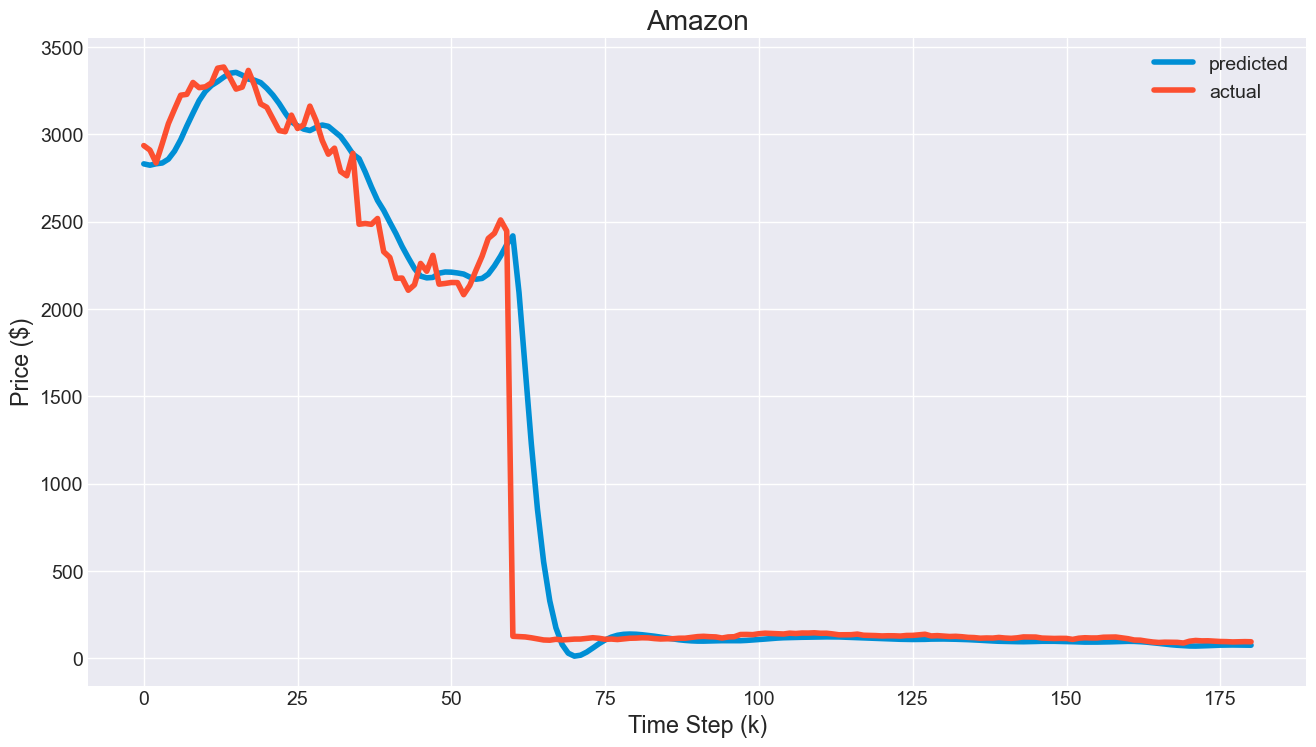

<Figure size 1400x800 with 0 Axes>

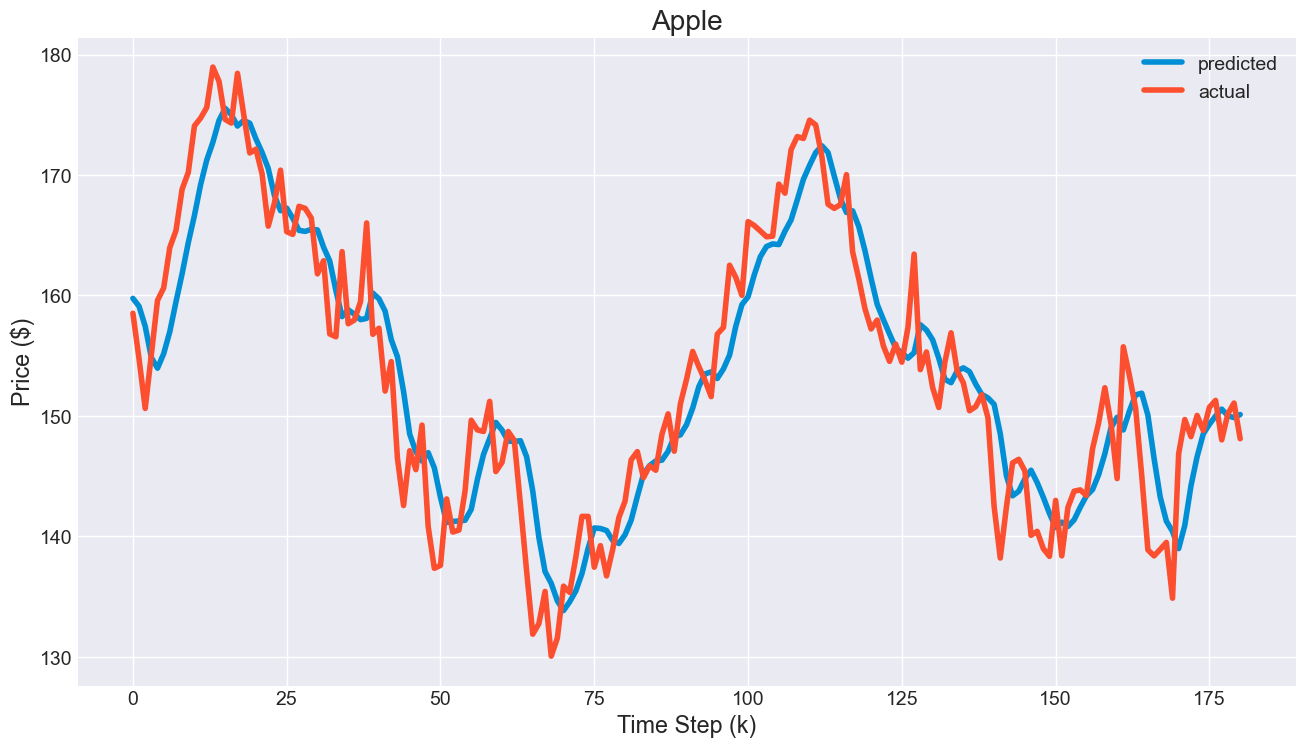

<Figure size 1400x800 with 0 Axes>

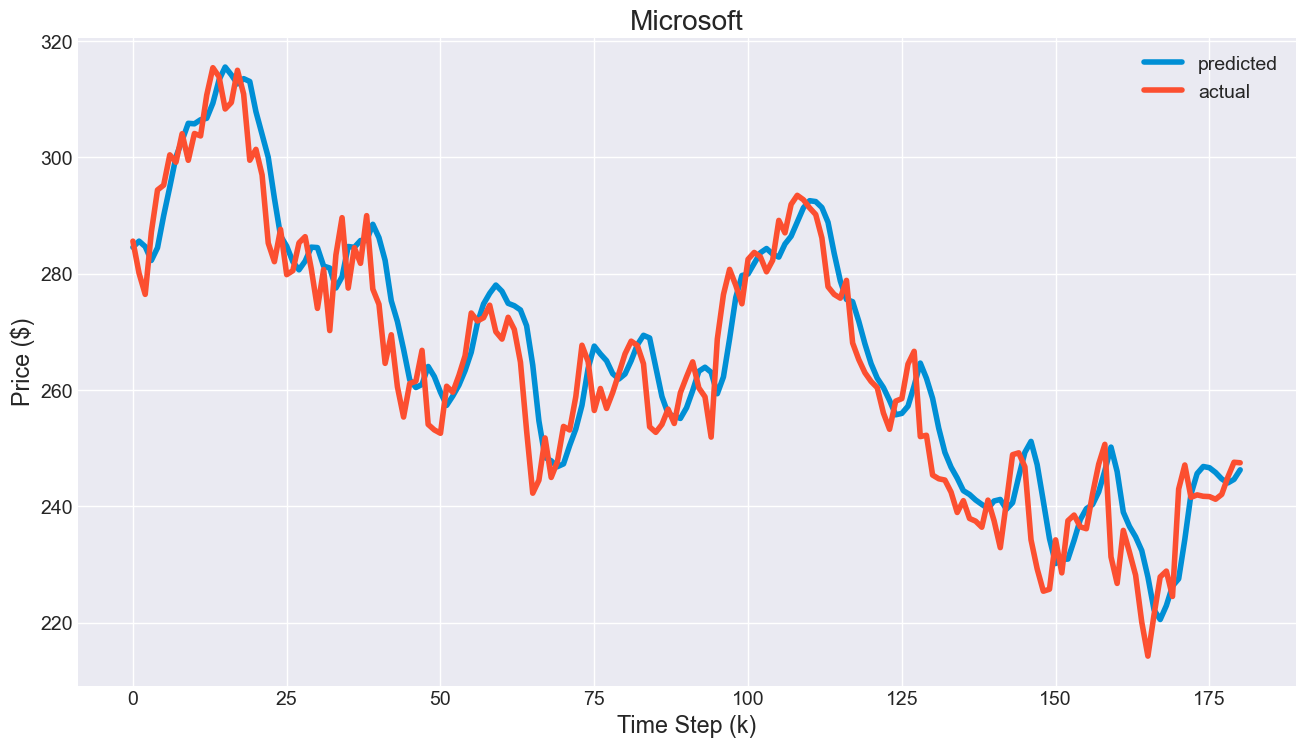

<Figure size 1400x800 with 0 Axes>

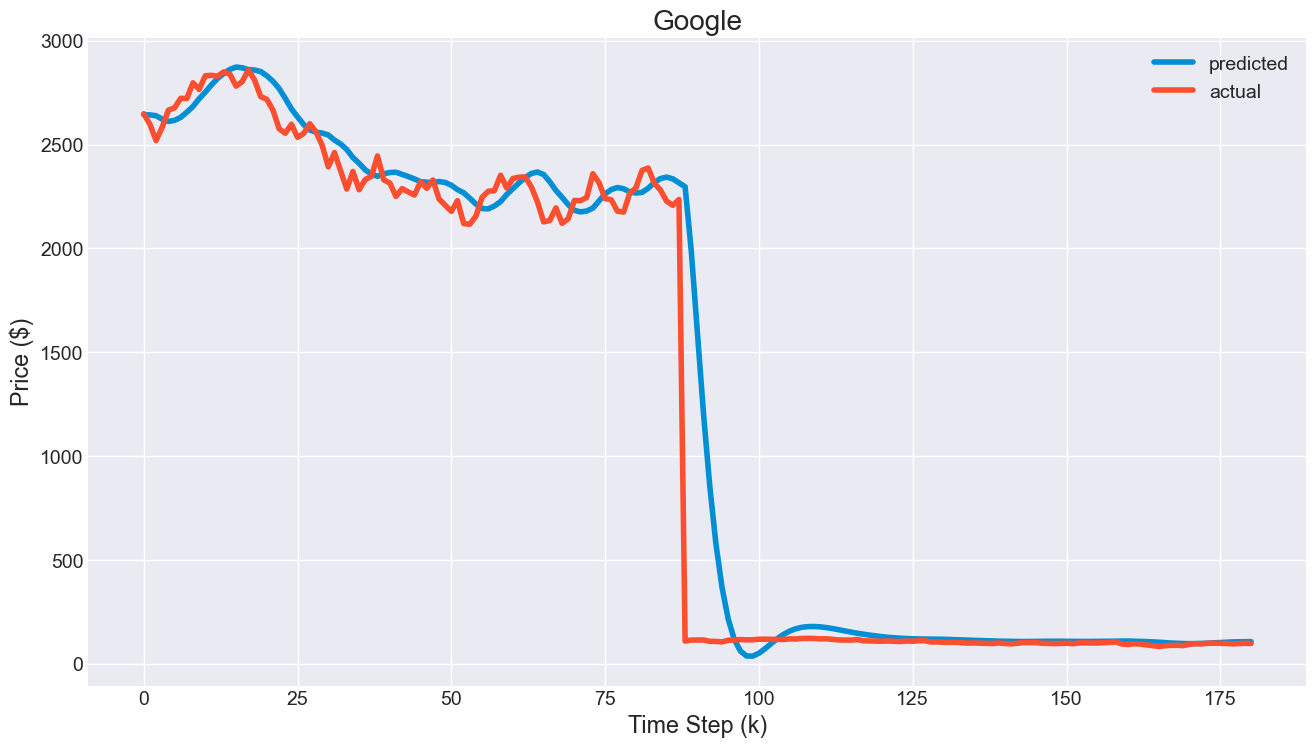

<Figure size 1400x800 with 0 Axes>

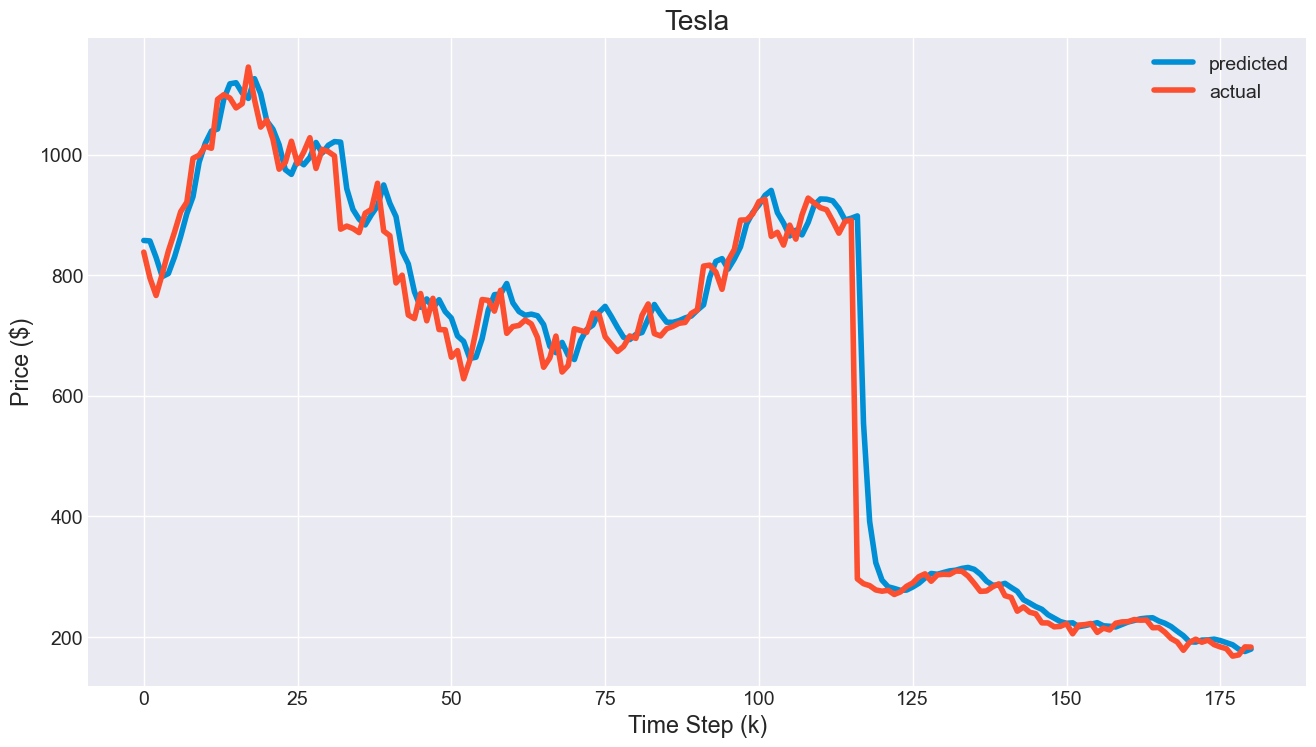

<Figure size 1400x800 with 0 Axes>

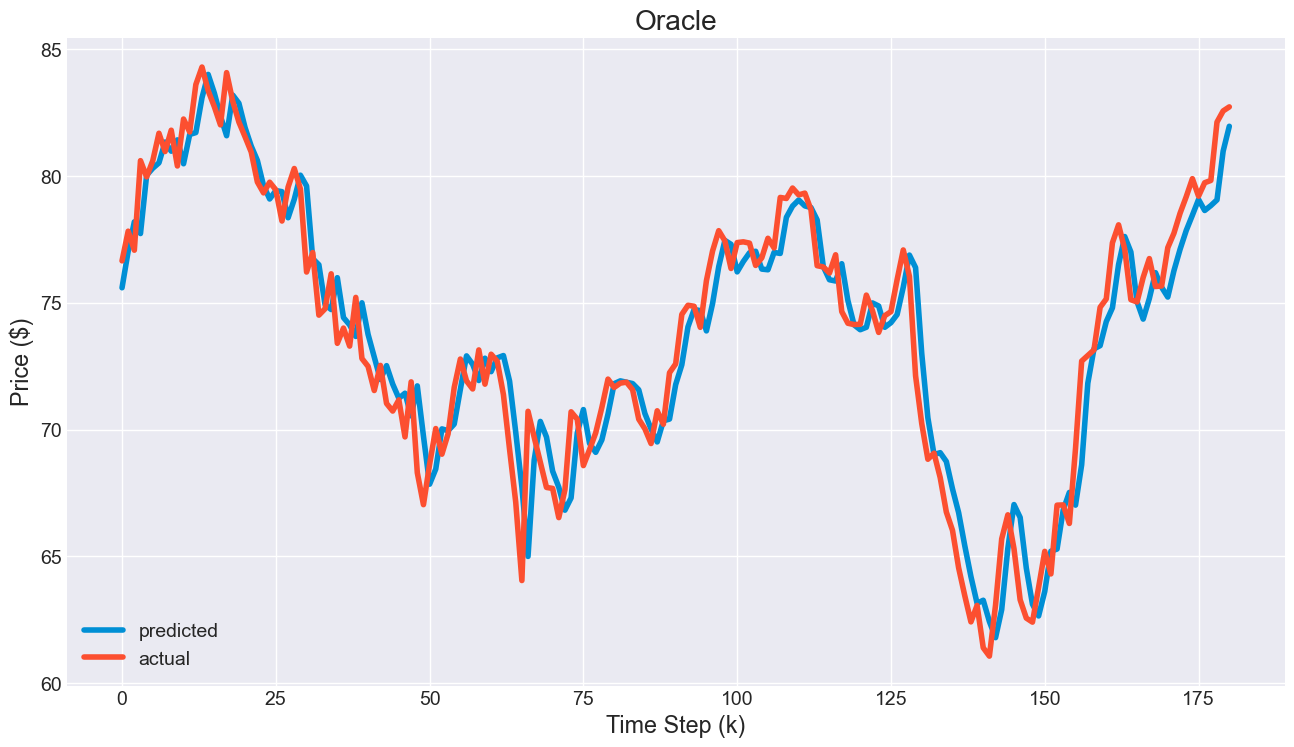

In [ ]:
companies_tingo = ['AMZN', 'AAPL', 'MSFT', 'GOOGL', 'TSLA', 'ORCL']
companies_name = ['Amazon', 'Apple', 'Microsoft', 'Google', 'Tesla', 'Oracle']

for idx in range(len(companies_tingo)):
    run_on_lstm_company_stock_price(companies_tingo[idx], companies_name[idx])